In [293]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing  
import time

In [278]:
def rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)

In [279]:
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [280]:
df_train['month'] = pd.DatetimeIndex(df_train.datetime).month
df_train['day'] = pd.DatetimeIndex(df_train.datetime).dayofweek
df_train['hour'] = pd.DatetimeIndex(df_train.datetime).hour
#df_train['dayofm'] = pd.DatetimeIndex(df_train.datetime).day
df_train = df_train.drop(['datetime','casual','registered'],axis=1)

In [281]:
df_train_train = df_train.drop(['count','holiday','workingday','weather','season'],axis = 1)
df_train_target = df_train['count']

In [290]:
df_train_train_1 = df_train_train[0:8000]
df_train_train_2 = df_train_train[8000+1:len(df_train_train)]
df_train_target_1 = df_train_target[0:8000]
df_train_target_2 = df_train_target[8000+1:len(df_train_target)]

In [317]:
time_start = time.clock()
ann = MLPClassifier(activation = 'relu', solver='adam', hidden_layer_sizes=(1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,),verbose=True,learning_rate='adaptive',warm_start=True,tol=1e-30,max_iter=1000,early_stopping=False).fit(preprocessing.scale(df_train_train_1),df_train_target_1)
time_elapsed = (time.clock() - time_start)

Iteration 1, loss = 6.05045508


In [323]:
print time_elapsed

185.103423


In [324]:
print ann.score(preprocessing.scale(df_train_train_1),df_train_target_1)

0.01875


In [325]:
pred_test = ann.predict(preprocessing.scale(df_train_train_2))
pred = np.array(pred_test)
target = np.array(df_train_target_2.values)

In [326]:
print rmsle(pred_test,target)

2.04746842314


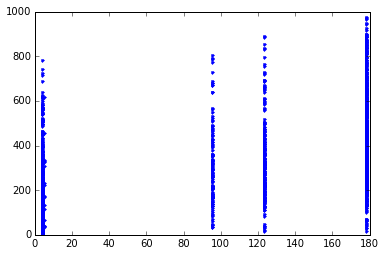

In [327]:
plt.plot(pred_test,target,'.')

In [313]:
df_test_test = df_test.drop(['holiday','workingday','weather','season'],axis = 1)
df_test_test['month'] = pd.DatetimeIndex(df_test_test.datetime).month
df_test_test['day'] = pd.DatetimeIndex(df_test_test.datetime).dayofweek
df_test_test['hour'] = pd.DatetimeIndex(df_test_test.datetime).hour
df_test_test = df_test_test.drop(['datetime'],axis = 1)

In [314]:
out = ann.predict(df_test_test)

In [315]:
pred = pd.DataFrame({'datetime': df_test['datetime'],'count': out})
pred = pred[['datetime','count']]

In [316]:
pred.to_csv("pred.csv", index = False)